# XAI Experiment Data Analysis

## Data Analysis todo list

- [x] Import and preprocess data
- [x] Demographics general overview 
- [X] Performance (accuracy etc.)
  - [X] AI vs Human vs Human-AI
  - [X] Compare Human-AI performance among groups (v1 vs v2 vs v3)
  - [ ] Compare Human-AI performance among groups and layperson vs journalists (including interaction effects)
- [ ] Willingness to adjust judgments to match the AI system (Agreement percentage, switch percentage and AI preference)
  - [X] Compare among groups (v1 vs v2 vs v3)
  - [ ] Compare among groups and layperson vs journalists (including interaction effects)
- [ ] Effects of mistakes of the system (FP and FN)
  - [ ] Performance and willingness to adjust at FP and FN compared to other news items
  - [ ] Local evaluation metrics of FP and FN compared to other news items
- [ ] Analysis of open questions
  - [ ] What criteria do you usually use to judge whether a news/article is reliable?
  - [ ] What other information would you like to obtain to better assess the truthfulness of an article?
  - [ ] What functionality would be a good addition?

In [1]:
import json
import pandas as pd
import requests
import io
from urllib.request import urlopen
import json
import logging
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.json import json_normalize
import pingouin as pg

## Import and preprocess data

### Read questionnaire data

In [2]:
df_v1 = pd.read_csv('data/v1_cleaned.csv')
df_v2 = pd.read_csv('data/v2_cleaned.csv')
df_v3 = pd.read_csv('data/v3_cleaned.csv')

In [3]:
# merge the two dataframes
df = pd.concat([df_v1, df_v2, df_v3], ignore_index=True)

In [4]:
# make sure seperate dataframes are not used
del df_v1
del df_v2
del df_v3

### Read news items

In [5]:
newsitems = pd.read_csv('../preprocessing/news-items.csv')

In [6]:
newsitems["id"] = newsitems.index + 1
newsitems.index = newsitems.index + 1

In [7]:
# only keep the relevant columns
newsitems = newsitems[["id", "label", "group",
                       "title", "subtitle", "content",
                       "source", "publishing_date", "category",
                       "highlighted_content", "truthfulness", "readability","natural_language_explanation",
                       "is_false_positive", "is_true_negative", "is_qualification"]]

In [8]:
# only keep newsitems from group 2 and newsitems without a group (FP and TN), 
# since only these are used in the experiment
newsitems = newsitems[(newsitems["group"] == 2) | newsitems["group"].isna()]
newsitems = newsitems.drop(columns=["group"])

In [9]:
# create a new column, "is_fake_news", based on if "label" is "FAKE" or "TRUE"
newsitems["is_fake_news"] = newsitems["label"].apply(lambda x: True if x == "FAKE" else False)
newsitems = newsitems.drop(columns=["label"])

In [10]:
# remove percentage sign from truthfulness and convert to int
newsitems["truthfulness"] = newsitems["truthfulness"].apply(lambda x: int(x.replace("%", "")))

In [11]:
newsitems

,id,title,subtitle,content,source,publishing_date,category,highlighted_content,truthfulness,readability,natural_language_explanation,is_false_positive,is_true_negative,is_qualification,is_fake_news
7,7,"Facing unbearable heat, Qatar has begun to air...",2°C: BEYOND THE LIMIT,"Already one of the hottest places on Earth, Qa...",Trustworthy Source,10/16/2019,Environment,"Already one of the hottest places on Earth, Qa...",90,medium,Qatar is one of the hottest countries on earth...,False,False,False,False
8,8,Survival International launches campaign to st...,NaN,Survival International today (Earth Day) launc...,Untrustworthy Source,04/22/2022,Environment,Survival International today (Earth Day) launc...,47,medium,The statement by Survival International that 3...,False,False,False,True
9,9,How Biden's climate plan could limit you to ea...,NaN,President Joe Biden's ambitious plan to slash ...,Untrustworthy Source,04/22/2021,Environment,President Joe Biden's ambitious plan to <span ...,5,easy,President Joe Biden’s climate plans do not inc...,False,False,False,True
10,10,Several Israelis wounded in attack on Jerusale...,Israeli police arrest suspected gunman after a...,Israeli police arrested a suspect in a shootin...,Trustworthy Source,8/14/2022,Crime,"""<mark>Israeli police arrested a suspect in a ...",92,medium,Israeli forces have allegedly been raiding hou...,False,False,True,False
11,11,Young Girl Hitchhiked Through The Middle East ...,NaN,Here’s a shocking and sad story that should be...,Untrustworthy Source,4/14/2016,Crime,"""<span style='background-color:#00FEFE'>Here’s...",21,easy,The article misleads the readers about the tim...,False,False,False,True
12,12,Military Arrests Bill Gates,NaN,The U.S. military on Tuesday arrested Microsof...,Untrustworthy Source,8/1/2021,Crime,"""The U.S. military on Tuesday arrested Microso...",3,easy,Real Raw News is a website that contains humor...,False,False,True,True
13,13,JOE BIDEN SAYS BIBLE BELIEVING CHRISTIANS VIOL...,"In too many places, Joe Biden said today, LGBT...",Vice President Joe Biden say today that the ri...,Untrustworthy Source,05/17/2015,Gender,<mark>Vice President Joe Biden say today that ...,97,easy,The NTEB headline misrepresented Biden's state...,True,False,False,True
14,14,Boys need to talk more about feelings and figh...,The Global Boyhood Initiative aims to enable a...,Boys should be encouraged to ignore gender ste...,Trustworthy Source,11/8/2022,Gender,Boys should be <span style='background-color:#...,10,hard,"""The State of UK Boys"" report has been release...",False,True,False,False


### Filtering out assumed cheaters

Assume that participants who did answer at least 5 out of 6 control questions correctly were paying attention and gave valid answers.

In [12]:
# participants who did not get 2 points in the qualification shouldn't be considered
df = df[df['POINTS.qualification'] == 2]

In [13]:
df = df[df["POINTS.main"] >= 5]

In [14]:
df["METADATA.FEATURE"].value_counts()

salient         140
basic           133
explanations    133
Name: METADATA.FEATURE, dtype: int64

## Demographics

In [15]:
# get columns which start with "demographics"
demographics_cols = [col for col in df.columns if col.startswith('demographics')]
demographics_cols
# country and nationality are not relevant, since the study was conducted in the US

['demographics.age',
 'demographics.country',
 'demographics.education',
 'demographics.employment',
 'demographics.gender',
 'demographics.income',
 'demographics.nationality']

In [16]:
df["demographics.age"].value_counts(normalize=True).sort_index() * 100

18-20           3.940887
21-29          25.862069
30-39          38.423645
40-49          22.906404
50-59           6.896552
60-or-older     1.970443
Name: demographics.age, dtype: float64

In [17]:
df["demographics.education"].value_counts(normalize=True) * 100
# university degree is the most common education level, this is surprising

university         54.187192
high-school        39.655172
no-degree           2.709360
secondary           2.216749
upper-secondary     1.231527
Name: demographics.education, dtype: float64

In [18]:
df["demographics.employment"].value_counts(normalize=True) * 100

salaried-employee    36.453202
self-employed        31.773399
unemployed           13.546798
student               9.852217
other                 6.403941
civil-servant         0.738916
retiree-pensioner     0.738916
apprentice            0.492611
Name: demographics.employment, dtype: float64

In [19]:
income_vc = df["demographics.income"].value_counts(normalize=True)
print("less-than-20000-usd", income_vc["less-than-20000-usd"] * 100)
print("20000-34999-usd", income_vc["20000-34999-usd"] * 100)
print("35000-49999-usd", income_vc["35000-49999-usd"] * 100)
print("50000-74999-usd", income_vc["50000-74999-usd"] * 100)
print("75000-99999-usd", income_vc["75000-99999-usd"] * 100)
print("over-100000-usd", income_vc["over-100000-usd"] * 100)
print("no-answer", income_vc["no-answer"] * 100)

less-than-20000-usd 14.285714285714285
20000-34999-usd 17.733990147783253
35000-49999-usd 10.83743842364532
50000-74999-usd 20.44334975369458
75000-99999-usd 12.068965517241379
over-100000-usd 13.546798029556651
no-answer 11.083743842364532


In [20]:
df["demographics.gender"].value_counts(normalize=True) * 100

female     63.546798
male       35.714286
diverse     0.738916
Name: demographics.gender, dtype: float64

## Define Kruskal-Wallis test function

In [75]:
def perform_kruskal_with_posthoc(df, col, print_results=True, between="METADATA.FEATURE"):
    if print_results:
        print("Column name:", col)

    kruskal_test = pg.kruskal(df, dv=col, between=between, detailed=True)
    kruskal_pval = kruskal_test["p-unc"].values[0]

    if print_results:
        print("kruskal_pval", kruskal_pval, "\n")


    posthoc = pg.pairwise_tests(df, dv=col, between=between, parametric=False, padjust="holm")

    # print stuff if p-corr is smaller than 0.05 in all the comparisons
    if print_results:
        print(posthoc, "\n")

    if print_results:
        print(df.groupby(between)[col].describe()[["mean", "std"]], "\n")

    return kruskal_test, posthoc, df.groupby(between)[col].describe()

## Performance

### AI vs Human vs Human-AI

How does the AI system perform compared to humans and the combination of human and AI? 

The task is to judge whether a news item is fake news or not, thus this is a binary classification problem. Since both the AI and participants are asked to rate the news items on a 0-100 scale, we use a threshold of 50, where ratings of <50 are treated as predicted fake news and ratings >=50 are treated as predicted truthful news.

The metrics for the AI are calculated over the 8 news items. Metrics are calculated for each participant seperately over the presented news items (e.g. a parcipant correctly judged 6 out of 8 news items, thus the accuracy is 6/8 = 0.75). Human-AI performance is measured after presenting the AI rating to the participants, this is also calculated for each participant seperately.

#### Calculate performance metrics of the AI system

In [24]:
RATING_THRESHOLD = 50

newsitems["is_fake_news_pred"] = newsitems["truthfulness"] < RATING_THRESHOLD

In [25]:
newsitems["is_fake_news"].value_counts()

True     5
False    3
Name: is_fake_news, dtype: int64

Since the dataset is unbalanced (5 fake news items and 3 truthful news items), we also use metrics that are more robust to unbalanced datasets than accuracy, such as precision, recall, F1-score and ROC AUC. Furthermore, a Brier score is calculated to measure the accuracy of the predicted probabilities.

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss, log_loss

ai_accuracy = accuracy_score(newsitems["is_fake_news"], newsitems["is_fake_news_pred"])
ai_precision = precision_score(newsitems["is_fake_news"], newsitems["is_fake_news_pred"])
ai_recall = recall_score(newsitems["is_fake_news"], newsitems["is_fake_news_pred"])
ai_f1 = f1_score(newsitems["is_fake_news"], newsitems["is_fake_news_pred"])
ai_roc_auc = roc_auc_score(newsitems["is_fake_news"], 1 - (newsitems["truthfulness"] / 100))
ai_brier_score = brier_score_loss(
    newsitems["is_fake_news"],
    newsitems["truthfulness"] / 100, 
    pos_label=0
)

ai_performance_df = pd.DataFrame({
  "accuracy": [ai_accuracy],
  "precision": [ai_precision],
  "recall": [ai_recall],
  "f1": [ai_f1],
  "roc_auc_score": [ai_roc_auc],
  "brier_score": [ai_brier_score]
})

ai_performance_df

,accuracy,precision,recall,f1,roc_auc_score,brier_score
0,0.75,0.8,0.8,0.8,0.666667,0.254462


#### Calculate performance metrics of the participants and Human-AI teams

In [27]:
def calculate_human_metrics(row):
    y_true = newsitems["is_fake_news"]
    y_pred_human = []
    y_pred_human_prob = []
    y_pred_human_ai = []
    y_pred_human_ai_prob = []

    for i in y_true.index:
        y_pred_human.append(row[f"newsitem.{i}.rating-before-xai"] < 50)
        y_pred_human_prob.append(row[f"newsitem.{i}.rating-before-xai"] / 100)
        y_pred_human_ai.append(row[f"newsitem.{i}.rating-after-xai"] < 50)
        y_pred_human_ai_prob.append(row[f"newsitem.{i}.rating-after-xai"] / 100)

    for i, _id in enumerate(y_true.index):
        # will be used later for comparing news items
        row[f"newsitem.{_id}.human-before-correct"] = y_true[_id] == y_pred_human[i]
        row[f"newsitem.{_id}.human-after-correct"] = y_true[_id] == y_pred_human_ai[i]

    human_accuracy = accuracy_score(y_true, y_pred_human)
    human_precision = precision_score(y_true, y_pred_human, zero_division=0)
    human_recall = recall_score(y_true, y_pred_human)
    human_f1 = f1_score(y_true, y_pred_human)
    human_roc_auc = roc_auc_score(y_true, 1 - np.array(y_pred_human_prob))
    human_brier_score = brier_score_loss(y_true, y_pred_human_prob, pos_label=0)

    human_ai_accuracy = accuracy_score(y_true, y_pred_human_ai)
    human_ai_precision = precision_score(y_true, y_pred_human_ai, zero_division=0)
    human_ai_recall = recall_score(y_true, y_pred_human_ai)
    human_ai_f1 = f1_score(y_true, y_pred_human_ai)
    human_ai_roc_auc = roc_auc_score(y_true, 1 - np.array(y_pred_human_ai_prob))
    human_ai_brier_score = brier_score_loss(y_true, y_pred_human_ai_prob, pos_label=0)

    row["human_accuracy"] = human_accuracy
    row["human_precision"] = human_precision
    row["human_recall"] = human_recall
    row["human_f1"] = human_f1
    row["human_roc_auc_score"] = human_roc_auc
    row["human_brier_score"] = human_brier_score

    row["human_ai_accuracy"] = human_ai_accuracy
    row["human_ai_precision"] = human_ai_precision
    row["human_ai_recall"] = human_ai_recall
    row["human_ai_f1"] = human_ai_f1
    row["human_ai_roc_auc_score"] = human_ai_roc_auc
    row["human_ai_brier_score"] = human_ai_brier_score

    return row

df = df.apply(calculate_human_metrics, axis=1)

#### Compare AI vs Human vs Human-AI

To compare the performance of the AI system to the performance of the participants and Human-AI teams, average the metrics over the participants.

In [30]:
# show mean human scores, mean human_ai scores and ai scores in one dataframe
human_scores = df[[
    "human_accuracy", 
    "human_precision", 
    "human_recall", 
    "human_f1", 
    "human_roc_auc_score",
    "human_brier_score",
]].copy()

human_ai_scores = df[[
    "human_ai_accuracy", 
    "human_ai_precision", 
    "human_ai_recall", 
    "human_ai_f1", 
    "human_ai_roc_auc_score",
    "human_ai_brier_score",
]].copy()

human_scores = human_scores.rename(columns=lambda x: x.replace("human_", ""))
human_ai_scores = human_ai_scores.rename(columns=lambda x: x.replace("human_ai_", ""))

human_scores = human_scores.mean()
human_ai_scores = human_ai_scores.mean()


In [33]:
scores_df = pd.DataFrame({
  "ai": ai_performance_df.iloc[0],
  "human": human_scores,
  "human_ai": human_ai_scores,
})

scores_df

,ai,human,human_ai
accuracy,0.750000,0.730911,0.818350
precision,0.800000,0.849748,0.897223
recall,0.800000,0.706404,0.809360
f1,0.800000,0.749796,0.840796
roc_auc_score,0.666667,0.806076,0.884975
brier_score,0.254462,0.181032,0.134820


In [34]:
scores_plot_df = pd.melt(
  scores_df.drop(["brier_score"]).reset_index(), 
  id_vars=["index"], 
  value_vars=["ai", "human", "human_ai"]
)

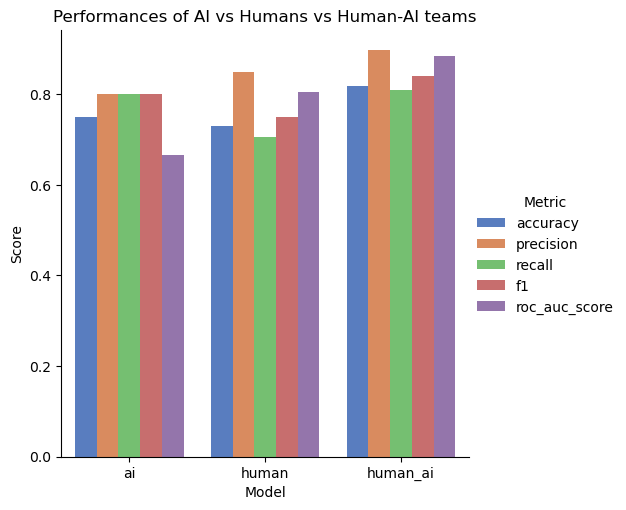

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

c = sns.catplot(x="variable", y="value", hue="index", data=scores_plot_df,  palette="muted", kind="bar")
plt.title("Performances of AI vs Humans vs Human-AI teams")
plt.ylabel("Score")
plt.xlabel("Model")
c._legend.set_title("Metric")

We use a Wilcoxon signed-rank test to determine if there is a significant difference in performance of participans before and after seeing the AI scores (and explanations).

In [40]:
wilcoxon_test = pg.wilcoxon(df["human_accuracy"], df["human_ai_accuracy"])
wilcoxon_test

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,5429.5,two-sided,4.044244e-24,-0.694207,0.345625


In [42]:
df[["human_accuracy", "human_ai_accuracy"]].describe()

,human_accuracy,human_ai_accuracy
count,406.000000,406.000000
mean,0.730911,0.818350
std,0.158179,0.137579
min,0.375000,0.375000
25%,0.625000,0.750000
50%,0.750000,0.875000
75%,0.875000,0.875000
max,1.000000,1.000000


Significant difference in accuracy before and after seeing the AI score. Human accuracy before is 0.730911. Human accuracy after (= Human-AI accuracy) is 0.818350. (AI accuracy is 0.750000)

### Compare Human-AI performance among groups (v1 vs v2 vs v3)

We use a Kruskal-Wallis H-test to determine if there is a significant difference in performance of the Human-AI teams among the groups.

In [44]:
kruskal, pairwise, stats = perform_kruskal_with_posthoc(df, "human_ai_accuracy", print_results=False);

In [45]:
kruskal

,Source,ddof1,H,p-unc
Kruskal,METADATA.FEATURE,2,0.320474,0.851942


High p-value (0.851942) indicates that there is no significant difference in performance among the groups.

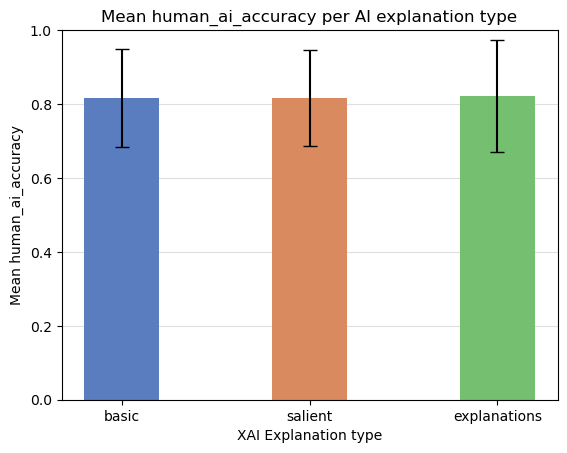

In [49]:
col = "human_ai_accuracy"

accuracy_data = df.groupby("METADATA.FEATURE")[col].describe()[["mean", "std"]].reset_index()
accuracy_data["METADATA.FEATURE"] = pd.Categorical(accuracy_data["METADATA.FEATURE"], categories=["basic", "salient", "explanations"], ordered=True)
accuracy_data = accuracy_data.sort_values("METADATA.FEATURE")

fig, ax = plt.subplots()
sns.barplot(x="METADATA.FEATURE", y="mean", data=accuracy_data, ax=ax, palette="muted", width=.4)
ax.set_ylabel(f"Mean {col}")
ax.set_xlabel("XAI Explanation type")
ax.set_ylim(0, 1)
ax.set_title(f"Mean {col} per AI explanation type")
ax.errorbar(x=accuracy_data["METADATA.FEATURE"], y=accuracy_data["mean"], yerr=accuracy_data["std"], fmt='none', c='black', capsize=5)
# have a grid on the y-axis
ax.set_axisbelow(True)
ax.yaxis.grid(True, which='major', color='grey', alpha=.25)

### Compare change in performance among groups (v1 vs v2 vs v3)

In [54]:
df["accuracy_change"] = df["human_ai_accuracy"] - df["human_accuracy"]

In [55]:
df["accuracy_change"].describe()

count    406.000000
mean       0.087438
std        0.152568
min       -0.375000
25%        0.000000
50%        0.125000
75%        0.125000
max        0.625000
Name: accuracy_change, dtype: float64

On average, accuracy of the participants increased by 0.087438 after seeing the AI score. We use a Kruskal-Wallis H-test to determine if there is a significant difference in change in performance of the participants among the groups.

In [59]:
kruskal, pairwise, stats = perform_kruskal_with_posthoc(df, "accuracy_change", print_results=False);

In [62]:
kruskal

,Source,ddof1,H,p-unc
Kruskal,METADATA.FEATURE,2,5.674691,0.058581


There is no significant difference in change in performance among the groups.

## Willingness to adjust judgments to match the AI system

In [67]:
def agrees_with_ai(row, newsitem_id):
    ai_rating = newsitems[newsitems["id"] == newsitem_id]["truthfulness"].values[0]
    human_rating = row[f"newsitem.{newsitem_id}.rating-after-xai"]
    return (human_rating < 50) == (ai_rating < 50)

def switched_ratings(row, newsitem_id):
    ai_rating = newsitems[newsitems["id"] == newsitem_id]["truthfulness"].values[0]
    human_rating_before = row[f"newsitem.{newsitem_id}.rating-before-xai"]
    human_rating_after = row[f"newsitem.{newsitem_id}.rating-after-xai"]
    
    return ((human_rating_before < 50) != (human_rating_after < 50)
            ) and ((human_rating_after < 50) == (ai_rating < 50))

def calculate_ai_preference(row, newsitem_id):
    rating_before_col = f"newsitem.{i}.rating-before-xai"
    rating_after_col = f"newsitem.{i}.rating-after-xai"
    ai_rating = newsitems[newsitems["id"] == newsitem_id]["truthfulness"].values[0]

    if row[rating_before_col] == ai_rating:
        if ai_rating == row[rating_after_col]:
            return 1
        else:
            return 0
    else:
        return min(1, max(0, (row[rating_after_col] - row[rating_before_col]) / (ai_rating - row[rating_before_col])))
    
for i in range(7, 15):
    df[f"newsitem.{i}.agrees-with-ai"] = df.apply(lambda row: agrees_with_ai(row, i), axis=1)
    df[f"newsitem.{i}.switched-to-ai"] = df.apply(lambda row: switched_ratings(row, i), axis=1)
    df[f"newsitem.{i}.ai-preference"] = df.apply(lambda row: calculate_ai_preference(row, i), axis=1)

In [68]:
agrees_with_ai_cols = [col for col in df.columns if col.startswith('newsitem') and col.endswith('agrees-with-ai')]
switched_to_ai_cols = [col for col in df.columns if col.startswith('newsitem') and col.endswith('switched-to-ai')]
ai_preference_cols = [col for col in df.columns if col.startswith('newsitem') and col.endswith('ai-preference')]

# calculate average AI preference over all newsitems
df["agrees-with-ai"] = df[agrees_with_ai_cols].mean(axis=1)
df["switched-to-ai"] = df[switched_to_ai_cols].mean(axis=1)
df["ai-preference"] = df[ai_preference_cols].mean(axis=1)

In [89]:
kruskal, posthoc, stats = perform_kruskal_with_posthoc(df, "ai-preference");

Column name: ai-preference
kruskal_pval 0.000119669564317498 

           Contrast             A             B  Paired  Parametric    U-val  \
0  METADATA.FEATURE         basic  explanations   False       False   7104.0   
1  METADATA.FEATURE         basic       salient   False       False  10309.5   
2  METADATA.FEATURE  explanations       salient   False       False  11998.0   

  alternative     p-unc    p-corr p-adjust    hedges  
0   two-sided  0.005545  0.011090     holm -0.325073  
1   two-sided  0.125494  0.125494     holm  0.160249  
2   two-sided  0.000038  0.000113     holm  0.482682   

                      mean       std
METADATA.FEATURE                    
basic             0.509299  0.205499
explanations      0.576165  0.204720
salient           0.475976  0.209125 



In [90]:
perform_kruskal_with_posthoc(df, "agrees-with-ai");

Column name: agrees-with-ai
kruskal_pval 0.005216588496215046 

           Contrast             A             B  Paired  Parametric    U-val  \
0  METADATA.FEATURE         basic  explanations   False       False   7219.0   
1  METADATA.FEATURE         basic       salient   False       False   9418.0   
2  METADATA.FEATURE  explanations       salient   False       False  11140.0   

  alternative     p-unc    p-corr p-adjust    hedges  
0   two-sided  0.006941  0.013883     holm -0.321403  
1   two-sided  0.864163  0.864163     holm  0.014156  
2   two-sided  0.003469  0.010407     holm  0.345823   

                      mean       std
METADATA.FEATURE                    
basic             0.736842  0.146182
explanations      0.781015  0.127258
salient           0.734821  0.138618 



In [91]:
perform_kruskal_with_posthoc(df, "switched-to-ai");

Column name: switched-to-ai
kruskal_pval 0.006381658943733156 

           Contrast             A             B  Paired  Parametric    U-val  \
0  METADATA.FEATURE         basic  explanations   False       False   7899.5   
1  METADATA.FEATURE         basic       salient   False       False  10357.5   
2  METADATA.FEATURE  explanations       salient   False       False  11323.0   

  alternative     p-unc    p-corr p-adjust    hedges  
0   two-sided  0.123774  0.198357     holm -0.181025  
1   two-sided  0.099179  0.198357     holm  0.217095  
2   two-sided  0.001584  0.004753     holm  0.403911   

                      mean       std
METADATA.FEATURE                    
basic             0.223684  0.178809
explanations      0.256579  0.183554
salient           0.186607  0.161836 



In [92]:
pg.cronbach_alpha(df[["ai-preference", "agrees-with-ai", "switched-to-ai"]])

(0.8186625030487245, array([0.786, 0.847]))

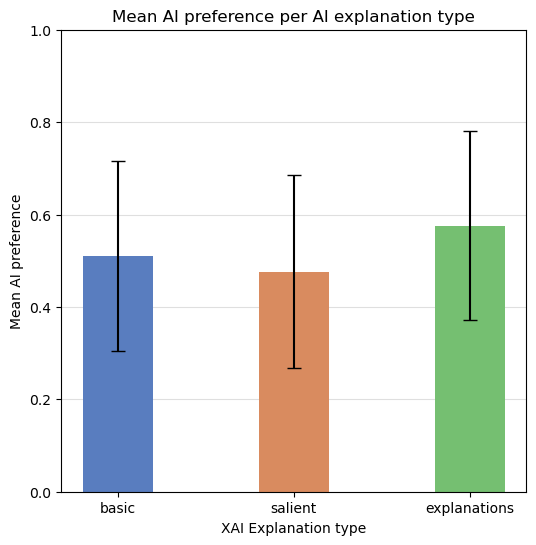

In [93]:
ai_pref_data = df.groupby("METADATA.FEATURE")["ai-preference"].describe()[["mean", "std"]].reset_index()
ai_pref_data["METADATA.FEATURE"] = pd.Categorical(ai_pref_data["METADATA.FEATURE"], categories=["basic", "salient", "explanations"], ordered=True)
ai_pref_data = ai_pref_data.sort_values("METADATA.FEATURE")

fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x="METADATA.FEATURE", y="mean", data=ai_pref_data, ax=ax, palette="muted", width=.4)
ax.set_ylabel("Mean AI preference")
ax.set_xlabel("XAI Explanation type")
ax.set_ylim(0, 1)
ax.set_title("Mean AI preference per AI explanation type")
ax.errorbar(x=ai_pref_data["METADATA.FEATURE"], y=ai_pref_data["mean"], yerr=ai_pref_data["std"], fmt='none', c='black', capsize=5)
# have a grid on the y-axis
ax.set_axisbelow(True)
ax.yaxis.grid(True, which='major', color='grey', alpha=.25)

*TODO*: Interpretation of results

## Effects of mistakes of the system

In [ ]:
# TODO

In [ ]:
local_eval_data = []

for ind, row in df.iterrows():
    for i in range(7, 15):
        local_eval_data.append(
            {
                "newsitem": i,
                "classified-correctly": row[f"newsitem.{i}.system-evaluation.classified-correctly"],
                # "explanations-comprehensible-and-help-assess": row[f"newsitem.{i}.system-evaluation.explanations-comprehensible-and-help-assess"],
                # "indications-useful": row[f"newsitem.{i}.system-evaluation.indications-useful"],
                # "understand-what-system-does": row[f"newsitem.{i}.system-evaluation.understand-what-system-does"],
                # "xai-features-useful": row[f"newsitem.{i}.system-evaluation.xai-features-useful"],
                # "human-before-correct": row[f"newsitem.{i}.human-before-correct"],
                # "human-after-correct": row[f"newsitem.{i}.human-after-correct"],
                # "ai-preference": row[f"newsitem.{i}.ai-preference"],
                # "switched-to-ai": row[f"newsitem.{i}.switched-to-ai"],
            }
        )

local_eval_df = pd.DataFrame(local_eval_data)


In [ ]:
local_eval_means = local_eval_df.groupby("newsitem").mean().reset_index()

local_eval_means =  pd.melt(local_eval_means, id_vars="newsitem", var_name="measure")
local_eval_means

In [ ]:
sns.catplot(x="newsitem", y="value", hue="measure", data=local_eval_means,  palette="muted", kind="bar")

# show the numbers on the x axis for values 13 and 14 in red


plt.show();

## Analysis of open questions

In [ ]:
# TODO